## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/Users/ag/Documents/ML/Project/taxi.csv', index_col=[0], parse_dates=[0])
#df = pd.read_csv('/datasets/autos.csv')

df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [3]:
df = df.dropna()

# 2. Анализ

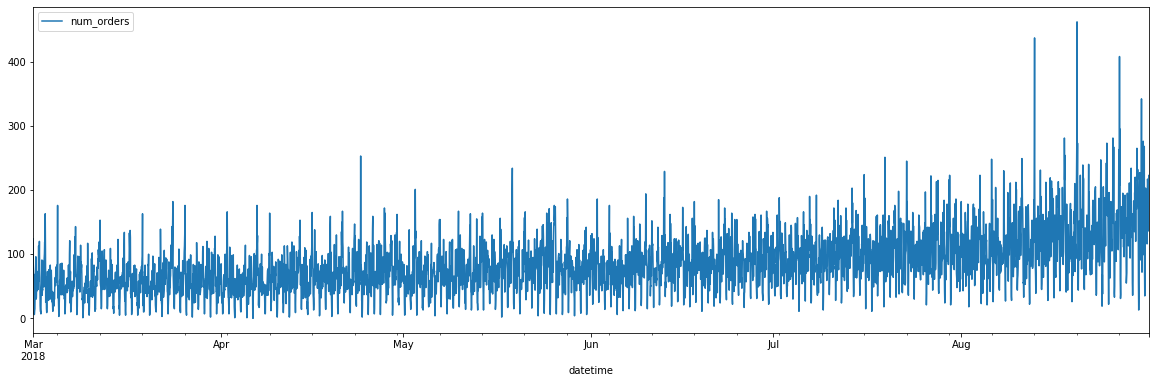

In [4]:
df.plot(figsize=(20, 6))

- в данных виден восходящий тренд и, судя по всему, внутрисуточная повторяемость
- к сожалению о сезонности судить мы не сможем, поскольку имеем данные даже не за целый год
- чтобы лучше разобраться с данными, сделаем новые признаки
- пишем функцию по созданию календарных признаков, отстающих значений и скользящего среднего

In [5]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

- для того, чтобы удобнее было анализировать данные, задействуем написанную ранее функцию 
- на новых признаках смотреть на данные будет удобнее

- в аргементы функции передаем максимальный размер отставания и ширину окна скользящего среднего

!!!! в это место мы еще вернемся и поменяем значения на подобранные по результатам этого анализа !!!

In [6]:
make_features(df, 72, 4)

- смотрим на график заказов в разрезе календарной недели

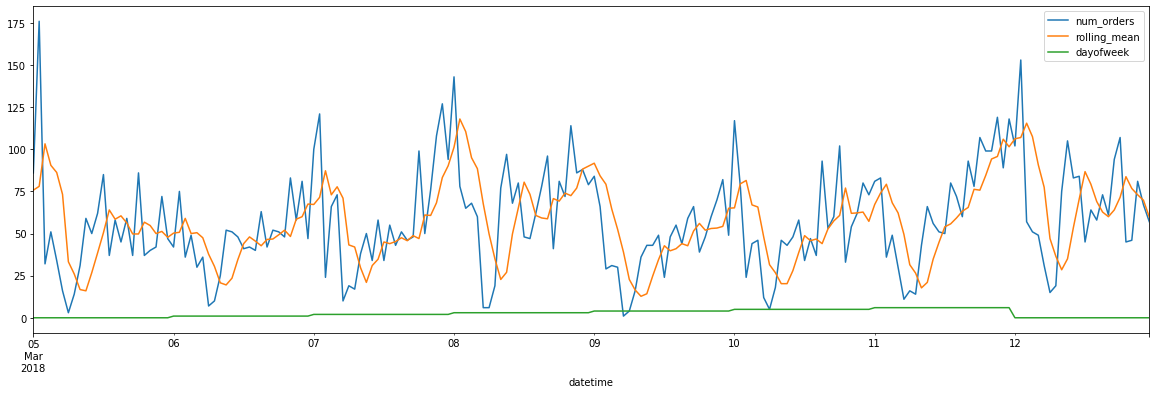

In [7]:
df['2018-03-05':'2018-03-12'][['num_orders', 'rolling_mean', 'dayofweek']].plot(figsize=(20, 6))

- определенно присутствует повторяемость внутри суток, причем она смещена относительно часов, четко выраженные подножия пиков приходятся строго на утренние часы каждого дня внутри недели
- также можно сказать, что внутри почти любого дня есть восходящий тренд
- также некоторые дни имеют характерные различия между собой: так в понедельник внутридневной тренд не восходит, а воскресенье имеет самый высокий пик среди всех

- в общем, это все можно было бы объяснить регулярностью пассажиропотока, но мы смотрим детализацию дальше

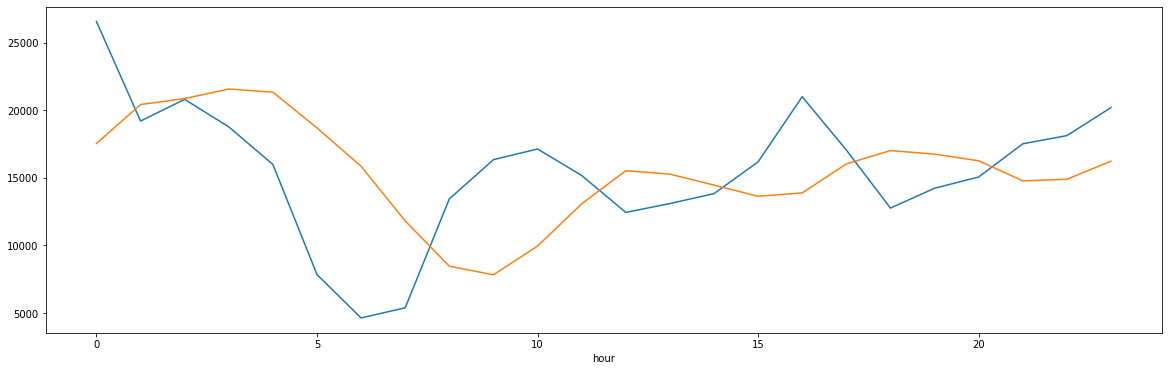

In [8]:
for column in ['num_orders', 'rolling_mean']:
    df.groupby('hour')[column].sum().plot(figsize=(20,6))

- да, действительно, суммарно внутри дня есть довольно существенный провал в количестве заказов в утренние часы

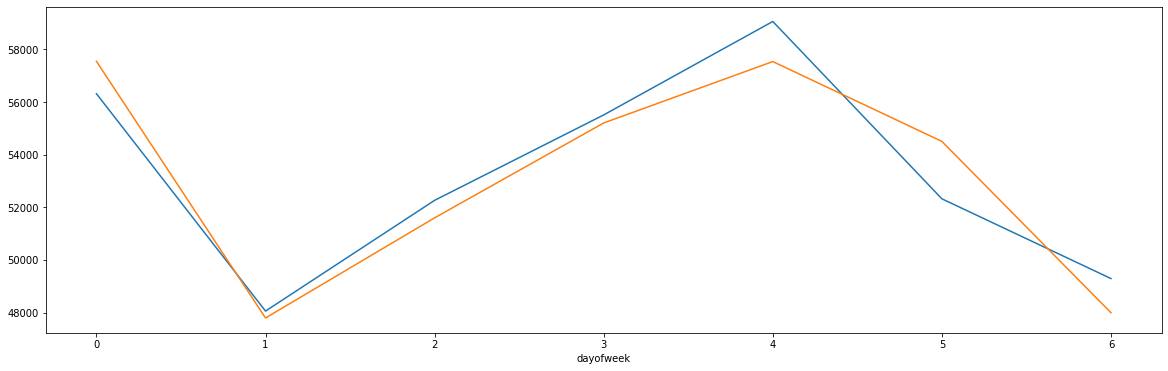

In [9]:
for column in ['num_orders', 'rolling_mean']:
    df.groupby('dayofweek')[column].sum().plot(figsize=(20,6))

- а в разрезе дней недели этот провал приходится на понедельник

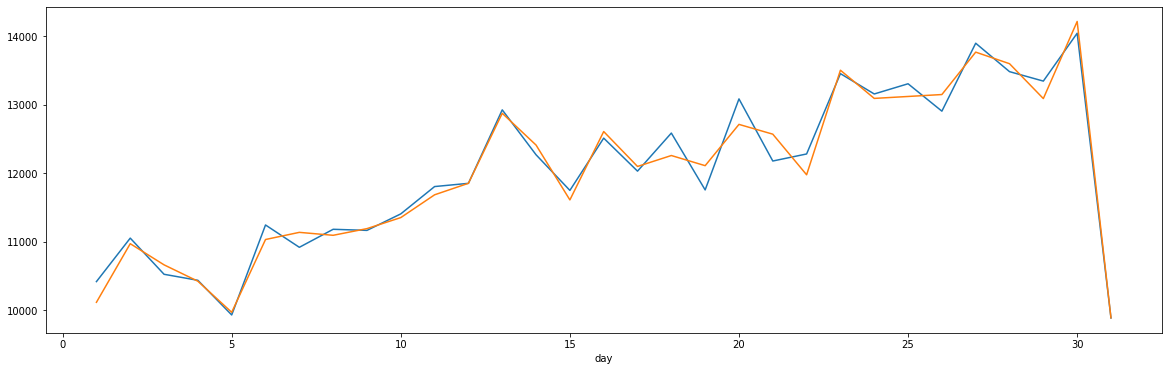

In [10]:
for column in ['num_orders', 'rolling_mean']:
    df.groupby('day')[column].sum().plot(figsize=(20,6))

- на графике дней месяца прослеживается восходящий тренд, который объясняется на еще большем уровне детализации
- а также есть провал на 31 числе месяца, ввиду того, что не у каждого месяца он есть

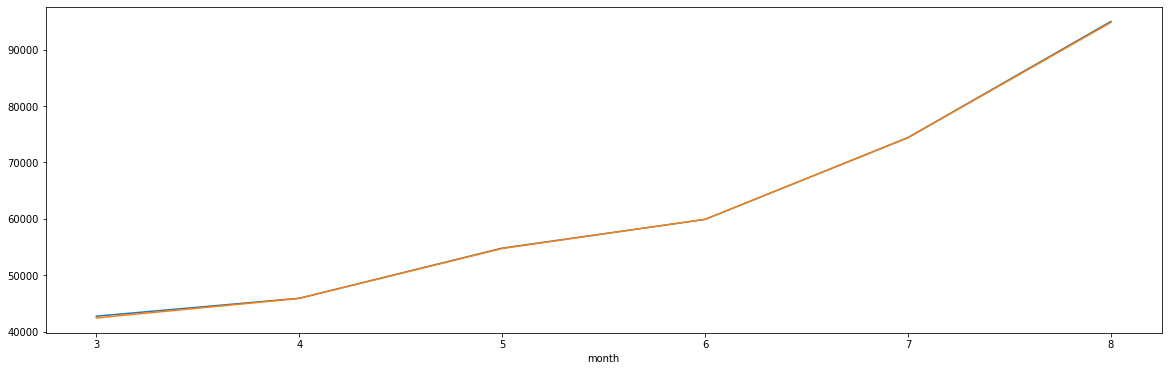

In [11]:
for column in ['num_orders', 'rolling_mean']:
    df.groupby('month')[column].sum().plot(figsize=(20,6))

- график по месяцам подтверждает наличие четкого восходящего тренда, который наверняка объясняется общим увеличением бизнеса такси

- резюмирую все выше рассмотренное, вернемся назад и подставим в функцию создания признаков параметры для отстающих и скользящего среднего, которые: 1) позволят учитывать общий тренд 2) дают оперативную информацию
- то есть признаки должны в любой момент времени отражать исторические данные как минимум за пару дней назад (отстающие) чтобы машина понимала на каком временном отрезке общего тренда находится, а также давать относительно оперативную информацию о среднем уровне заказов (скользящее) чтобы учесть внутрисуточные колебания
- с этими мыслями возвращаемся выше на ячейку с созданием признаков и выставляем 3 суток и 4 часа, соответственно

# 3. Обучение

In [12]:
from sklearn.model_selection import train_test_split

- из признаков также удаляем не нужный в этом проекте год

In [13]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()

features_train = train.drop(['num_orders', 'year'], axis=1)
target_train = train[['num_orders']]

features_test = test.drop(['num_orders', 'year'], axis=1)
target_test = test[['num_orders']]

### Линейная регрессия

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [15]:
model = LinearRegression()
model.fit(features_train, target_train)
print("RMSE обучающей выборки:", mean_squared_error(target_train, model.predict(features_train), squared=False))
print("RMSE тестовой выборки: ", mean_squared_error(target_test, model.predict(features_test), squared=False))

RMSE обучающей выборки: 22.58854663513532
RMSE тестовой выборки:  42.475768912162856


- на этом в принципе можно было бы заканчивать, целевой RMSE пройден с запасом уже на линейной регрессии

### LightGBM

- но для улучшения результата проведем обучение LGBM

In [18]:
%pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [19]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [20]:
import hyperopt as hp
from hyperopt import Trials,fmin,STATUS_OK

In [21]:
import warnings
warnings.filterwarnings("ignore")

- подбираем параметры с помощью hyperopt
- лимит по времени подбора делаем не более 10 мин по локальной машине, чтобы сильно много не ждать

In [28]:
import lightgbm as lgb
from lightgbm import Dataset


def objective(params, n_folds=3):

    d_train = lgb.Dataset(features_train,target_train)    

    cv_results = lgb.cv(params, d_train, nfold = n_folds, num_boost_round = 500, 
                        early_stopping_rounds = 25, metrics = 'l2_root', seed = 0)
    # print(cv_results)
    loss = min(cv_results['rmse-mean'])
    return loss


lgb_space = {
    'max_depth':hp.hp.choice('max_depth', np.arange(10, 30, 1, dtype=int)),
    'subsample':hp.hp.quniform('subsample',0.2,1.0,0.05),
    'colsample_bytree':hp.hp.quniform('colsample_bytree',0.2,1.0,0.05),
    'min_child_weight':hp.hp.quniform('min_child_weight', 100, 1000,100),
    'reg_alpha': hp.hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.hp.uniform('reg_lambda', 0.0, 1.0)}
    
    
bayes_trials = Trials()
MAX_EVALS = 300

best_params = fmin(fn = objective, space = lgb_space, algo = hp.tpe.suggest, 
max_evals = MAX_EVALS, trials = bayes_trials)

100%|██████████| 300/300 [10:41<00:00,  2.14s/trial, best loss: 21.82838832559843] 


In [29]:
print("Hyperopt предлагает: {}".format(best_params))

Hyperopt предлагает: {'colsample_bytree': 0.30000000000000004, 'max_depth': 7, 'min_child_weight': 100.0, 'reg_alpha': 0.6674273763204273, 'reg_lambda': 0.7054498397538893, 'subsample': 0.65}


# 4. Тестирование

In [30]:
d_train_lgb = lgb.Dataset(features_train,target_train)
params_lgb = best_params

In [31]:
%%time
model_lgb = lgb.train(params_lgb, d_train_lgb,num_boost_round = 500)

CPU times: user 6.63 s, sys: 285 ms, total: 6.92 s
Wall time: 1.1 s


In [32]:
%%time
pred_lgb = model_lgb.predict(features_test)
print("RMSE тестовой выборки:", mean_squared_error(target_test, pred_lgb, squared=False))

RMSE тестовой выборки: 38.4398635242685
CPU times: user 40.2 ms, sys: 4.11 ms, total: 44.3 ms
Wall time: 12.5 ms


- собственно, результат линейной регрессии мы улучшили, можно заканчивать

## Вывод

1. Данные о заказах такси имеют отчетливые тренды и внутрисуточные колебания, которые на окне прогнозирования в 1 час пришлось учитывать подбором параметров при создании дополнительных признаков
2. Целевой RMSE преодолен на LGBM с запасом.

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48